<a href="https://colab.research.google.com/github/Cesar-Curitol/Challenge_Telecom_X_an-lisis_de-evasi-n_de_clientes_Parte-2/blob/main/Challenge_Telecom_X_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# Imports y configuración
# =========================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 200)


In [ ]:
# =========================
# Cargar datos limpios
# =========================
URL = "https://raw.githubusercontent.com/Cesar-Curitol/Challenge_Telecom_X_an-lisis_de-evasi-n_de_clientes_Parte-2/refs/heads/main/TelecomX_Data_limpio.csv"
df = pd.read_csv(URL, encoding="utf-8-sig")

print("Shape:", df.shape)
df.head()


Shape: (7043, 22)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,TenureMeses,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,CargoMensual,CargoTotal,Cuentas_Diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,No,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2.796667


In [ ]:
# =========================
# Limpieza + columnas irrelevantes
# =========================
# Quitar identificadores que no aportan al target
for col in ["customerID"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Asegurar tipo de Churn => 0/1
# Si viniera como Yes/No, mapeamos; si ya es 0/1, convertimos a int
if df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].map({"Yes":1, "No":0})
df["Churn"] = pd.to_numeric(df["Churn"], errors="coerce").fillna(0).astype(int)

# Reporte de balance de clases
dist = df["Churn"].value_counts().rename({0:"No",1:"Sí"})
print("Distribución de Churn:\n", dist, "\nProporción (%):\n", (dist / dist.sum() * 100).round(2))


Distribución de Churn:
 Churn
No    5174
Sí    1869
Name: count, dtype: int64 
Proporción (%):
 Churn
No    73.46
Sí    26.54
Name: count, dtype: float64


In [ ]:
# =========================
# Selección de columnas por tipo
# =========================
target = "Churn"
feature_cols = [c for c in df.columns if c != target]

# Heurística: categóricas = object o category; numéricas = resto
cat_cols = list(df[feature_cols].select_dtypes(include=["object", "category"]).columns)
num_cols = [c for c in feature_cols if c not in cat_cols]

print("Numéricas:", num_cols[:10], "...", f"({len(num_cols)})")
print("Categóricas:", cat_cols[:10], "...", f"({len(cat_cols)})")


Numéricas: ['SeniorCitizen', 'Partner', 'Dependents', 'TenureMeses', 'PhoneService', 'PaperlessBilling', 'CargoMensual', 'CargoTotal', 'Cuentas_Diarias'] ... (9)
Categóricas: ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract'] ... (11)


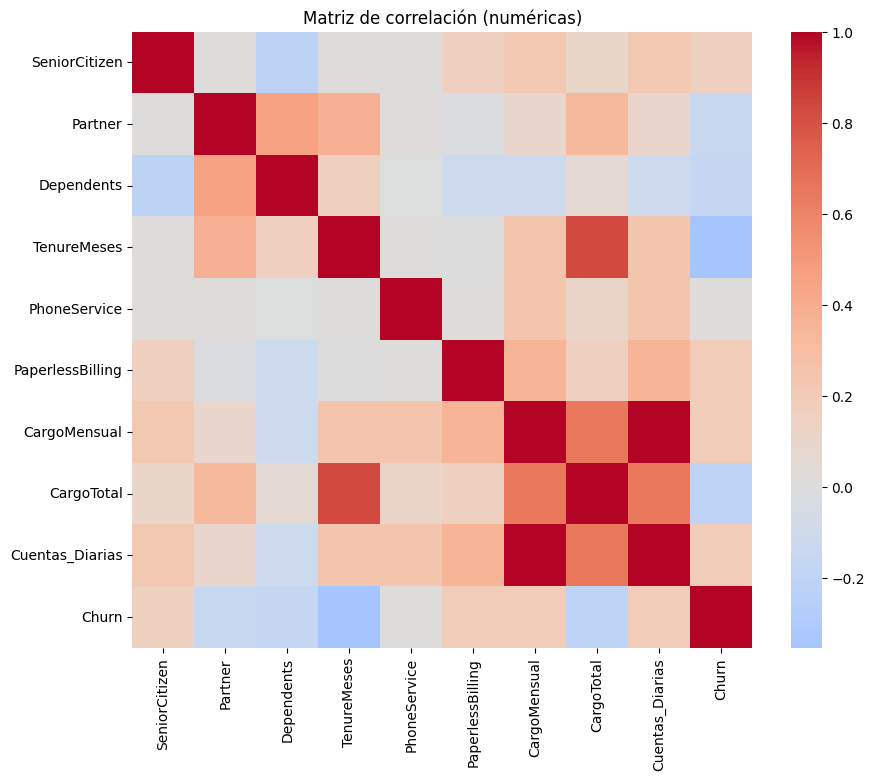

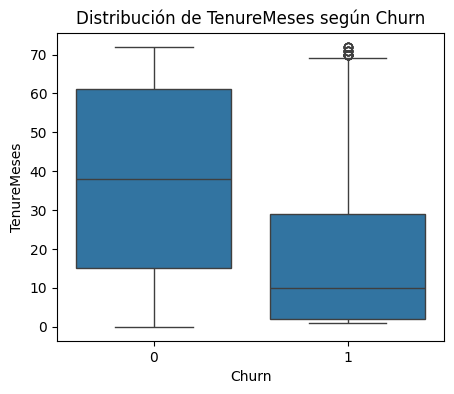

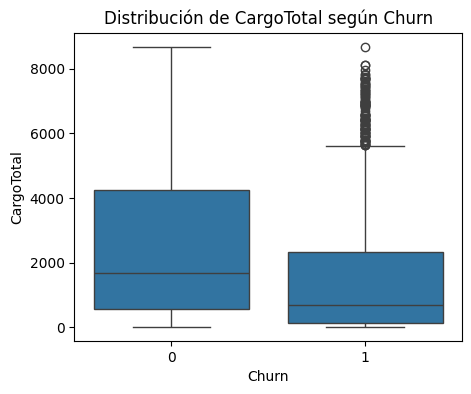

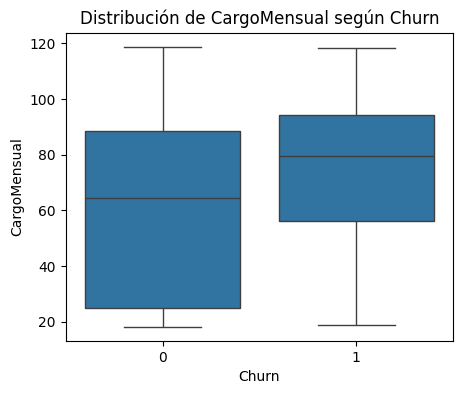

In [ ]:
# =========================
# Correlación (solo numéricas)
# =========================
corr = df[num_cols + [target]].corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de correlación (numéricas)")
plt.show()

# =========================
# Análisis dirigido: TenureMeses y CargoTotal vs Churn
# Ajusta los nombres si en tu dataset quedaron distintos
# =========================
cand_vars = [c for c in ["TenureMeses", "CargoTotal", "CargoMensual"] if c in df.columns]

for col in cand_vars:
    plt.figure(figsize=(5,4))
    sns.boxplot(data=df, x=target, y=col)
    plt.title(f"Distribución de {col} según Churn")
    plt.show()


In [ ]:
# =========================
# Split 80/20
# =========================
X = df[feature_cols].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((5634, 20), (1409, 20))

In [ ]:
# =========================
# Preprocesamiento (con escala)
# =========================
num_transformer_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", num_transformer_scaled, num_cols),
        ("cat", cat_transformer_ohe, cat_cols)
    ],
    remainder="drop"
)

# =========================
# Preprocesamiento (sin escala)
# =========================
num_transformer_noscale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess_noscale = ColumnTransformer(
    transformers=[
        ("num", num_transformer_noscale, num_cols),
        ("cat", cat_transformer_ohe, cat_cols)
    ],
    remainder="drop"
)


In [ ]:
# =========================
# Modelo 1: Regresión Logística (con estandarización)
# =========================
log_reg = Pipeline(steps=[
    ("prep", preprocess_scaled),
    ("clf", LogisticRegression(
        max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced", n_jobs=None
    ))
])

# =========================
# Modelo 2: Random Forest (sin estandarizar)
# =========================
rf = Pipeline(steps=[
    ("prep", preprocess_noscale),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=2,
        random_state=RANDOM_STATE, n_jobs=-1, class_weight=None
    ))
])

# Entrenar
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'TenureMeses',
                                                   'PhoneService',
                                                   'PaperlessBilling',
                                                   'CargoMensual', 'CargoTotal',
                                                   'Cuentas_Diarias']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])


=== Regresión Logística (scaled) ===
Accuracy:  0.7402
Precisión: 0.5069
Recall:    0.7834
F1-score:  0.6155
ROC-AUC:   0.8432

Matriz de confusión:
[[750 285]
 [ 81 293]]

Classification report:
              precision    recall  f1-score   support

           0     0.9025    0.7246    0.8039      1035
           1     0.5069    0.7834    0.6155       374

    accuracy                         0.7402      1409
   macro avg     0.7047    0.7540    0.7097      1409
weighted avg     0.7975    0.7402    0.7539      1409



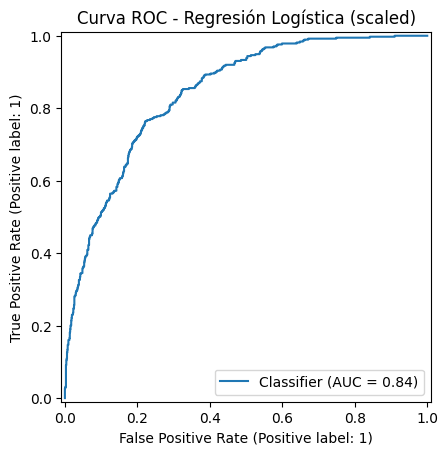


=== Random Forest ===
Accuracy:  0.7899
Precisión: 0.6364
Recall:    0.4866
F1-score:  0.5515
ROC-AUC:   0.8268

Matriz de confusión:
[[931 104]
 [192 182]]

Classification report:
              precision    recall  f1-score   support

           0     0.8290    0.8995    0.8628      1035
           1     0.6364    0.4866    0.5515       374

    accuracy                         0.7899      1409
   macro avg     0.7327    0.6931    0.7072      1409
weighted avg     0.7779    0.7899    0.7802      1409



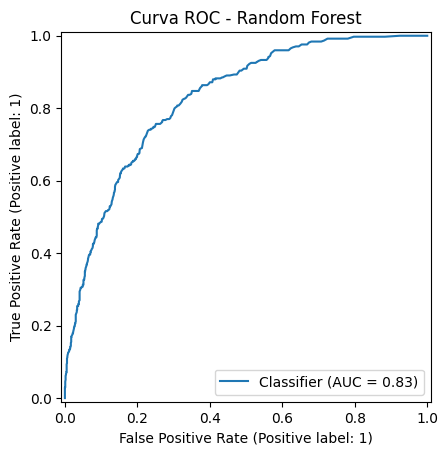

In [ ]:
def eval_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    # Probabilidad positiva (si está disponible)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        # Algunas SVM lineales
        from sklearn.preprocessing import MinMaxScaler
        # Escalamos a [0,1] para un pseudo-ROC si no hay proba
        y_scores = model.decision_function(X_test).reshape(-1,1)
        y_proba = MinMaxScaler().fit_transform(y_scores).ravel()

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1  = f1_score(y_test, y_pred, zero_division=0)
    cm  = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precisión: {pre:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    if y_proba is not None:
        roc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC:   {roc:.4f}")

    print("\nMatriz de confusión:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Curva ROC si hay proba
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Curva ROC - {name}")
        plt.show()

eval_model("Regresión Logística (scaled)", log_reg, X_test, y_test)
eval_model("Random Forest", rf, X_test, y_test)



Top 20 features - Random Forest:


,feature,importance
7,CargoTotal,0.168053
3,TenureMeses,0.155667
6,CargoMensual,0.129780
8,Cuentas_Diarias,0.128260
29,PaymentMethod_Electronic check,0.037883
12,InternetService_Fiber optic,0.033364
27,Contract_Two year,0.032621
9,gender_Male,0.024698
5,PaperlessBilling,0.023768
21,TechSupport_Yes,0.022600


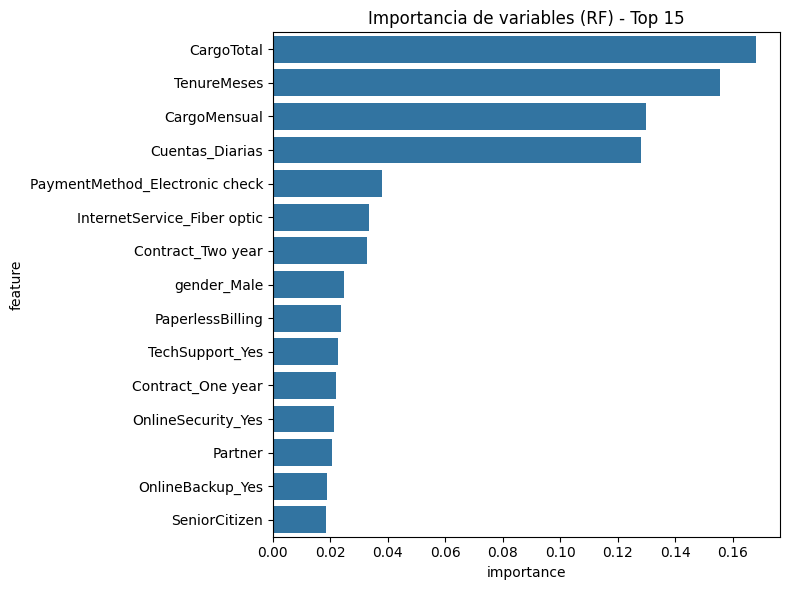


Top 20 coeficientes positivos - LogReg:


,feature,coef
12,InternetService_Fiber optic,1.004040
7,CargoTotal,0.597952
29,PaymentMethod_Electronic check,0.427284
23,StreamingTV_Yes,0.360770
11,MultipleLines_Yes,0.324687
25,StreamingMovies_Yes,0.268412
5,PaperlessBilling,0.169011
0,SeniorCitizen,0.080098
28,PaymentMethod_Credit card (automatic),0.034656
30,PaymentMethod_Mailed check,0.015469



Top 20 coeficientes negativos - LogReg:


,feature,coef
10,MultipleLines_No phone service,-0.023700
1,Partner,-0.028671
9,gender_Male,-0.066563
2,Dependents,-0.074790
4,PhoneService,-0.088573
17,OnlineBackup_Yes,-0.111574
16,OnlineBackup_No internet service,-0.163868
14,OnlineSecurity_No internet service,-0.163868
13,InternetService_No,-0.163868
24,StreamingMovies_No internet service,-0.163868


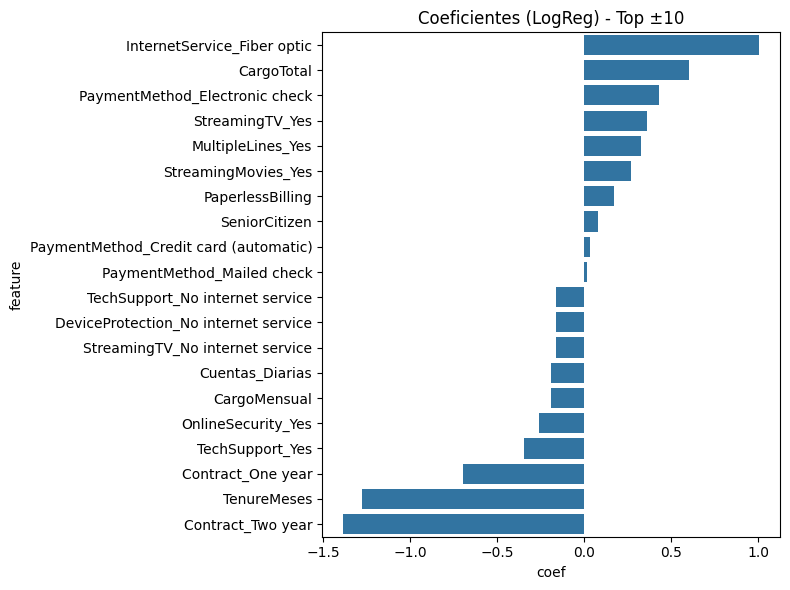

In [ ]:
# =========================
# Importancias - Random Forest
# =========================
# Obtenemos nombres de columnas transformadas desde el preprocesador
ohe = rf.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feat_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []

feature_names_rf = num_cols + cat_feat_names
importancias = rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names_rf, "importance": importancias}) \
           .sort_values("importance", ascending=False)

print("\nTop 20 features - Random Forest:")
display(imp_df.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(15), x="importance", y="feature")
plt.title("Importancia de variables (RF) - Top 15")
plt.tight_layout()
plt.show()

# =========================
# Coeficientes - Regresión Logística
# =========================
# Para LR, las columnas salen del preprocesador con escala + OHE
ohe_lr = log_reg.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feat_names_lr = list(ohe_lr.get_feature_names_out(cat_cols)) if len(cat_cols) else []
feat_names_lr = num_cols + cat_feat_names_lr

coefs = log_reg.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feat_names_lr, "coef": coefs}).sort_values("coef", ascending=False)

print("\nTop 20 coeficientes positivos - LogReg:")
display(coef_df.head(20))

print("\nTop 20 coeficientes negativos - LogReg:")
display(coef_df.tail(20))

plt.figure(figsize=(8,6))
sns.barplot(data=pd.concat([coef_df.head(10), coef_df.tail(10)]),
            x="coef", y="feature")
plt.title("Coeficientes (LogReg) - Top ±10")
plt.tight_layout()
plt.show()



=== LogReg + SMOTE ===
Accuracy:  0.7523
Precisión: 0.5220
Recall:    0.7941
F1-score:  0.6299
ROC-AUC:   0.8428

Matriz de confusión:
[[763 272]
 [ 77 297]]

Classification report:
              precision    recall  f1-score   support

           0     0.9083    0.7372    0.8139      1035
           1     0.5220    0.7941    0.6299       374

    accuracy                         0.7523      1409
   macro avg     0.7152    0.7657    0.7219      1409
weighted avg     0.8058    0.7523    0.7650      1409



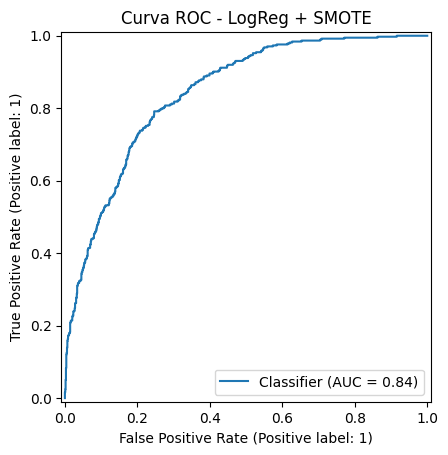

In [ ]:
# =========================
# SMOTE opcional (usar SOLO en train)
# =========================
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Tomamos la matriz transformada del pipeline de logística (ya escalada + ohe)
X_train_lr = log_reg.named_steps["prep"].fit_transform(X_train)
y_train_lr = y_train.copy()

sm = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = sm.fit_resample(X_train_lr, y_train_lr)

# Reentrenar solo el clasificador con datos SMOTE (mantenemos preprocesamiento)
log_reg_sm = LogisticRegression(
    max_iter=1000, random_state=RANDOM_STATE, class_weight=None
)
log_reg_sm.fit(X_train_sm, y_train_sm)

# Evaluar usando el MISMO X_test transformado
X_test_lr = log_reg.named_steps["prep"].transform(X_test)
eval_model("LogReg + SMOTE", log_reg_sm, X_test_lr, y_test)


In [ ]:
# =========================
# Exportables (opcional)
# =========================
# Guardar ranking de importancia RF
imp_df.to_csv("rf_feature_importance.csv", index=False, encoding="utf-8-sig")

# Guardar coeficientes LogReg
coef_df.to_csv("logreg_coefficients.csv", index=False, encoding="utf-8-sig")

print("Archivos guardados: rf_feature_importance.csv, logreg_coefficients.csv")


Archivos guardados: rf_feature_importance.csv, logreg_coefficients.csv


In [27]:
# =========================================
# Conclusión automática en Markdown (E2E)
# Requiere: df ya cargado desde tu URL
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- 1) Asegurar esquema y target ---
df_local = df.copy()
if "customerID" in df_local.columns:
    df_local.drop(columns=["customerID"], inplace=True)

if df_local["Churn"].dtype == "object":
    df_local["Churn"] = df_local["Churn"].map({"Yes":1, "No":0})
df_local["Churn"] = pd.to_numeric(df_local["Churn"], errors="coerce").fillna(0).astype(int)

target = "Churn"
feature_cols = [c for c in df_local.columns if c != target]
cat_cols = list(df_local[feature_cols].select_dtypes(include=["object","category"]).columns)
num_cols = [c for c in feature_cols if c not in cat_cols]

X = df_local[feature_cols].copy()
y = df_local[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# --- 2) Preprocesamiento ---
num_scaled = Pipeline([("imputer", SimpleImputer(strategy="median")),
                       ("scaler", StandardScaler())])
cat_ohe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))])

preprocess_scaled = ColumnTransformer([("num", num_scaled, num_cols),
                                       ("cat", cat_ohe, cat_cols)], remainder="drop")

preprocess_noscale = ColumnTransformer([("num", SimpleImputer(strategy="median"), num_cols),
                                        ("cat", cat_ohe, cat_cols)], remainder="drop")

# --- 3) Modelos ---
log_reg = Pipeline([
    ("prep", preprocess_scaled),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced"))
])

rf = Pipeline([
    ("prep", preprocess_noscale),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
])

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

def eval_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    return {
        "name": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        "cm": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred, digits=4)
    }

m_log = eval_metrics(log_reg, X_test, y_test, "Logistic Regression (scaled, balanced)")
m_rf  = eval_metrics(rf, X_test, y_test, "Random Forest")

# --- 4) Top drivers ---
# RF - importancias
ohe_rf = rf.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_names_rf = list(ohe_rf.get_feature_names_out(cat_cols)) if len(cat_cols) else []
feat_rf = num_cols + cat_names_rf
imp_rf = rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"feature": feat_rf, "importance": imp_rf}) \
          .sort_values("importance", ascending=False)
imp_df.to_csv("rf_feature_importance.csv", index=False, encoding="utf-8-sig")

# LogReg - coeficientes
ohe_lr = log_reg.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_names_lr = list(ohe_lr.get_feature_names_out(cat_cols)) if len(cat_cols) else []
feat_lr = num_cols + cat_names_lr
coef_lr = log_reg.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feat_lr, "coef": coef_lr}).sort_values("coef", ascending=False)
coef_df.to_csv("logreg_coefficients.csv", index=False, encoding="utf-8-sig")

# Tomar top variables interpretables
top_rf = imp_df.head(8).copy()
top_pos_lr = coef_df.head(8).copy()
top_neg_lr = coef_df.tail(8).copy()

# Heurística de nombres “amigables” si existen estas columnas
human_labels = {
    "TenureMeses": "Antigüedad (meses)",
    "CargoMensual": "Cargo Mensual",
    "CargoTotal": "Cargo Total",
    "Contract_Month-to-month": "Contrato: Month-to-month",
    "Contract_One year": "Contrato: One year",
    "Contract_Two year": "Contrato: Two year",
    "PaperlessBilling_Yes": "Paperless Billing: Sí",
    "PaymentMethod_Electronic check": "Payment: Electronic check",
    "TechSupport_Yes": "TechSupport: Sí",
    "OnlineSecurity_Yes": "OnlineSecurity: Sí"
}
def pretty(n):
    return human_labels.get(n, n)

top_rf["feature"] = top_rf["feature"].map(pretty)
top_pos_lr["feature"] = top_pos_lr["feature"].map(pretty)
top_neg_lr["feature"] = top_neg_lr["feature"].map(pretty)

# --- 5) Generar informe Markdown ---
def fmt_metrics(m):
    return (f"- **Accuracy**: {m['accuracy']:.3f}  \n"
            f"- **Precision**: {m['precision']:.3f}  \n"
            f"- **Recall**: {m['recall']:.3f}  \n"
            f"- **F1**: {m['f1']:.3f}  \n"
            f"- **ROC-AUC**: {m['roc_auc']:.3f}")

conclusion = f"""# Informe de Predicción de Churn — Telecom X

## Resumen de Modelos
**{m_log['name']}**
{fmt_metrics(m_log)}

**{m_rf['name']}**
{fmt_metrics(m_rf)}

## Principales Drivers de Cancelación
**Random Forest — Importancias (Top 8)**
{top_rf.to_markdown(index=False)}

**Regresión Logística — Coeficientes Positivos (Top 8)**
{top_pos_lr.to_markdown(index=False)}

**Regresión Logística — Coeficientes Negativos (Top 8)**
{top_neg_lr.to_markdown(index=False)}

## Conclusión Estratégica
- **Contrato Month-to-month** aparece como factor dominante de riesgo; **One/Two year** reduce la probabilidad de churn.
- **Antigüedad baja (Tenure)** eleva el riesgo de salida.
- **Cargo Mensual alto** sin acumulación de **Cargo Total** sugiere clientes recientes con mayor propensión a abandonar si no reciben valor rápido.
- La ausencia de **servicios de soporte/seguridad** (TechSupport/OnlineSecurity) se asocia a mayor churn.

## Recomendaciones
1. **Migración de contrato**: campañas para pasar clientes de `month-to-month` a **One/Two year** con incentivos (descuento/paquetes de valor).
2. **Onboarding 0–6 meses**: bundle de soporte/seguridad y comunicaciones de valor (8–12 semanas).
3. **Alertas tempranas**: activar score de churn con umbral optimizado; priorizar Tenure bajo + contrato mensual + cargo mensual alto sin addons.
4. **Métricas de éxito**: retención a 90 días en cohortes tratadas, uptake de upgrades a contratos anuales y reducción de churn en segmento mensual.

*Nota:* el modelo a priorizar depende del objetivo: **recall alto** (detección temprana) → LogReg; **desempeño global estable** → Random Forest.
"""

with open("informe_churn.md", "w", encoding="utf-8") as f:
    f.write(conclusion)

print("✅ Informe generado: informe_churn.md")
print("📦 Exportables: rf_feature_importance.csv, logreg_coefficients.csv")


✅ Informe generado: informe_churn.md
📦 Exportables: rf_feature_importance.csv, logreg_coefficients.csv
